Here we finetune BERT with no preprocessing on the data whatsoever. It servers as our baseline.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import umap
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from utils import get_length_info, get_cls_embeddings, aggregate_embeddings, process_and_merge_embeddings

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# Preprocessing

## Training Set

In [3]:
li_train = []
matchid_to_filename = {}

for filename in os.listdir("data/train_tweets"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

In [3]:
df_train

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,11_0,11,0,0,1404575400000,RT @2014WorIdCup: Argentina vs Belgium\n\nWho ...
1,11_0,11,0,0,1404575400000,@elijahman_ time to focus on Belgium winning t...
2,11_0,11,0,0,1404575400000,RT @FIFAWorldCup: GLOBAL STADIUM: #Joinin with...
3,11_0,11,0,0,1404575400000,RT @CatholicNewsSvc: #PopeFrancis. Uh-oh. Arge...
4,11_0,11,0,0,1404575400000,RT @soccerdotcom: If he scores vs #BEL we'll a...
...,...,...,...,...,...,...
5056045,18_129,18,129,0,1276876799000,RT @nytimes FIFA World Cup -- Final Score: U.S...
5056046,18_129,18,129,0,1276876799000,Ugh!!! should've been 3-2 USA! #worldcup
5056047,18_129,18,129,0,1276876799000,RT @jaclynkeough: Ha! RT @someecards I'd rathe...
5056048,18_129,18,129,0,1276876799000,RT @gustavaulia: So many surprises at worldcup...


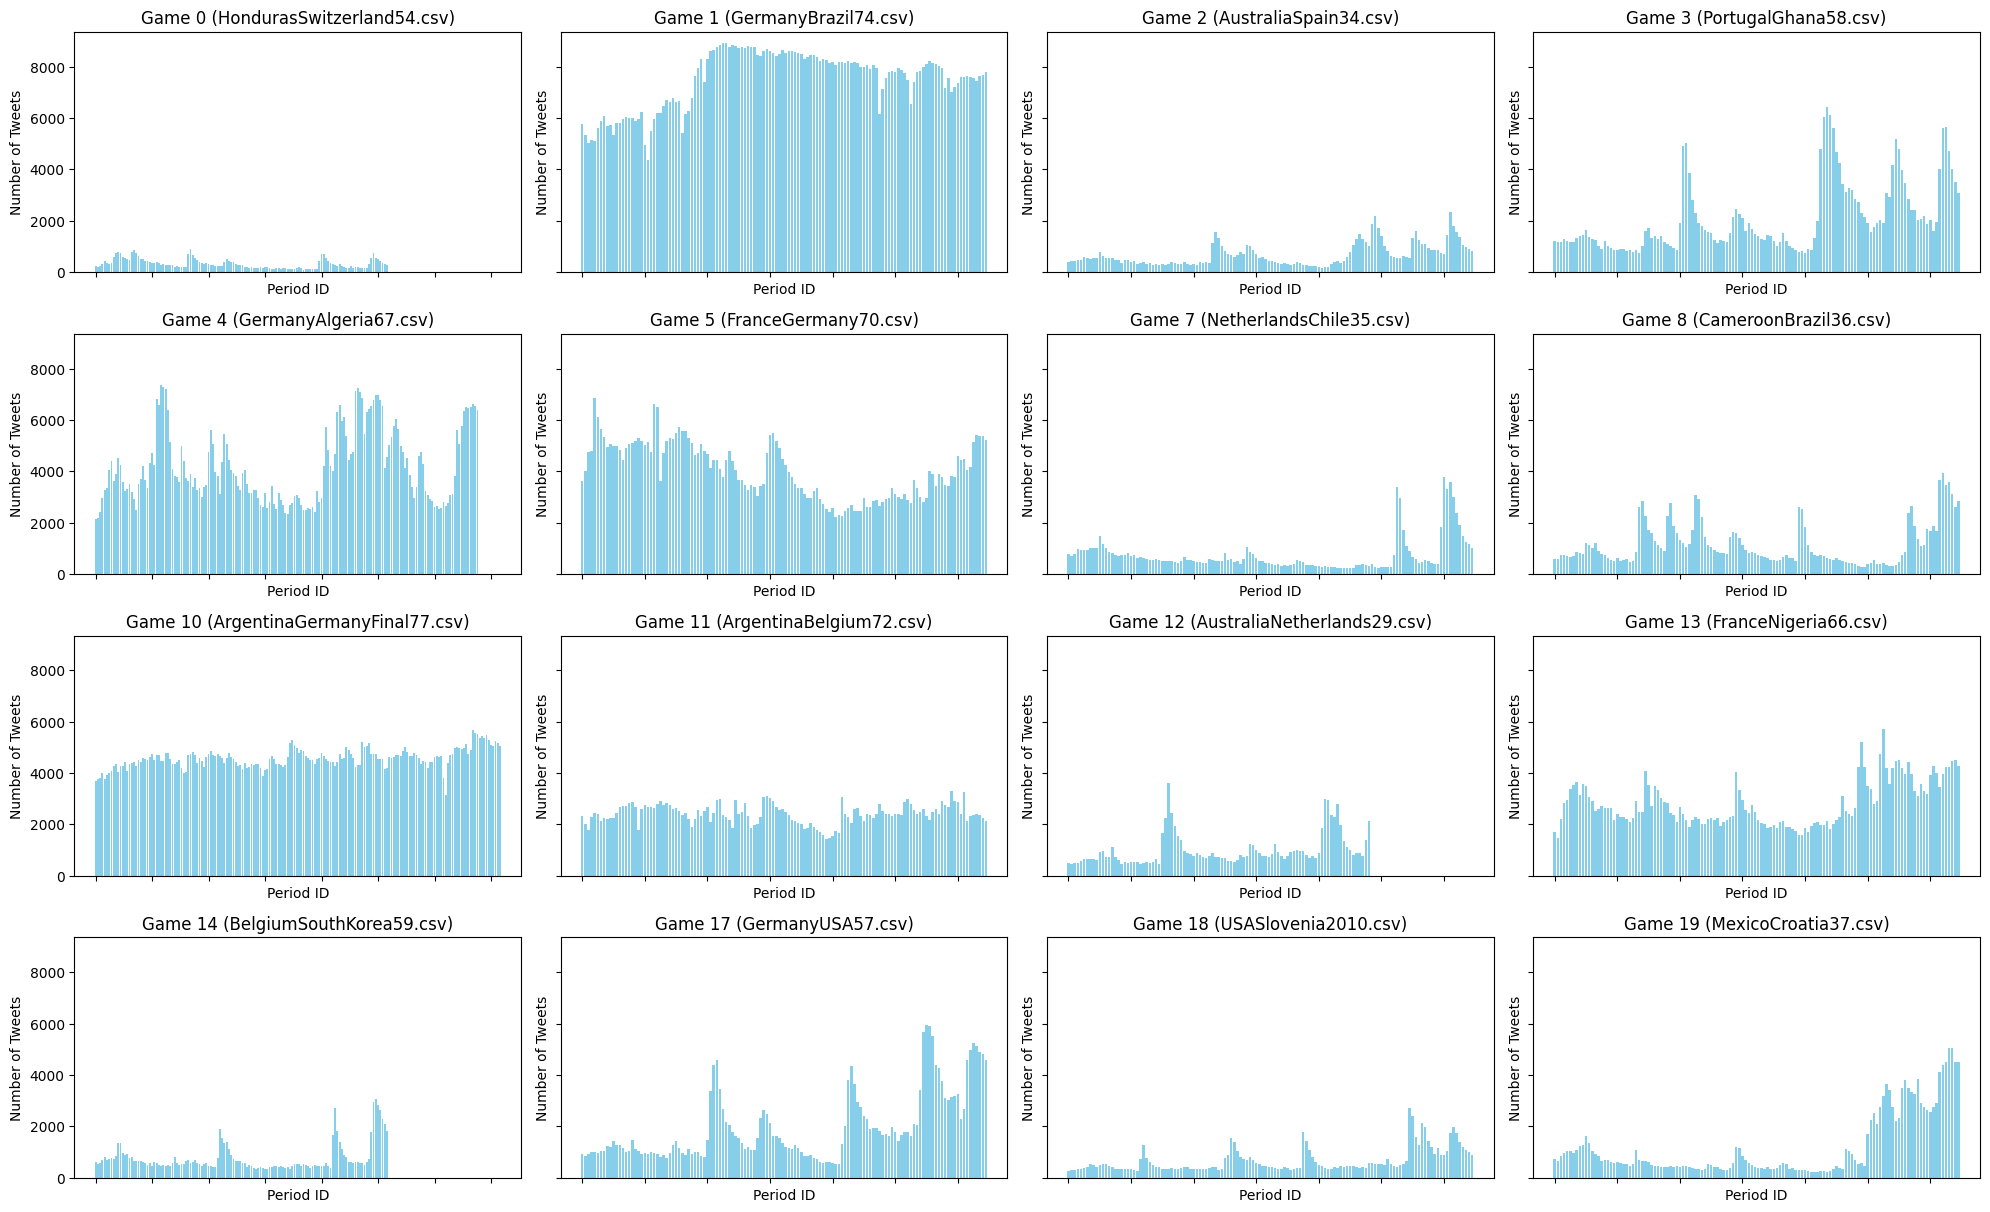

In [4]:
tweet_counts = df_train.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [5]:
print(f"Total number of periods in the train set: {len(df_train['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_train['PeriodID'].unique())}")

Total number of periods in the train set: 2137
Max number of periods in a game in the train set: 180


In [4]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 27.06
  50th percentile length: 26.00
  75th percentile length: 37.00
  90th percentile length: 43.00
  95th percentile length: 47.00
  99th percentile length: 53.00


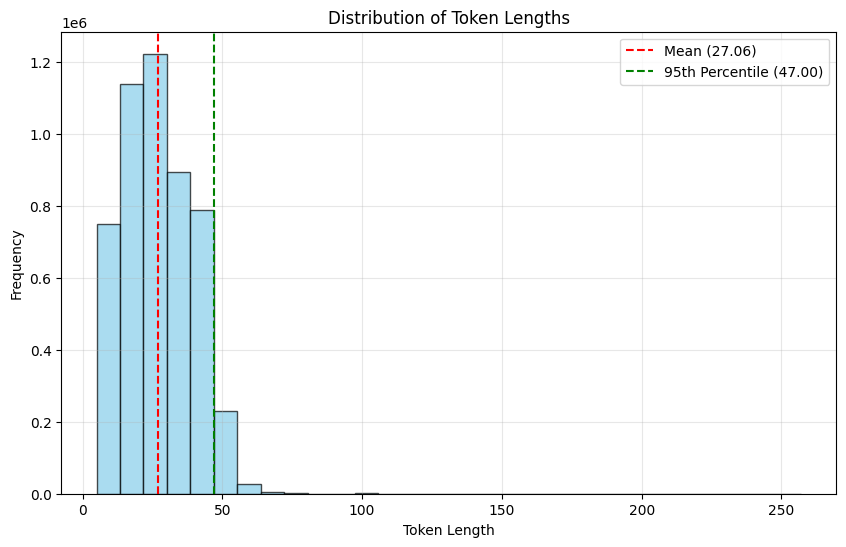

In [5]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

Let's choose 50 as our max length (checked also on test set below)

In [7]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/tokens_bertweet.pt")

In [9]:
# input_ids, attention_masks = torch.load("tokens_bertweet.pt")

In [10]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 158002/158002 [4:57:54<00:00,  8.84it/s]  


Done!


In [12]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [ ]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels.pkl
Saved!


In [14]:
merged_df

,ID,aggregated_embedding,EventType
0,0_0,"[0.038894046, 0.2056955, 0.1732219, -0.0507800...",0
1,0_1,"[0.049072143, 0.20504853, 0.16913632, -0.04101...",0
2,0_10,"[-0.010199165, 0.19084008, 0.142129, -0.027013...",1
3,0_100,"[0.1076907, 0.18990463, 0.13662358, -0.0059914...",1
4,0_101,"[0.110753596, 0.21662608, 0.14855266, -0.02414...",1
...,...,...,...
2132,8_95,"[-0.12547426, 0.10333069, 0.012717849, 0.00890...",0
2133,8_96,"[-0.13536794, 0.08814793, 0.013134736, -0.0146...",1
2134,8_97,"[-0.13311367, 0.09247862, 0.016269028, 0.00072...",1
2135,8_98,"[-0.12481897, 0.07730664, 0.014376387, 0.00727...",0


The vectors are already normalized.

## Test Set

We repeat the same.

In [6]:
li_test = []
matchid_to_filename_test = {}

for filename in os.listdir("data/eval_tweets"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

In [37]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...
...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...


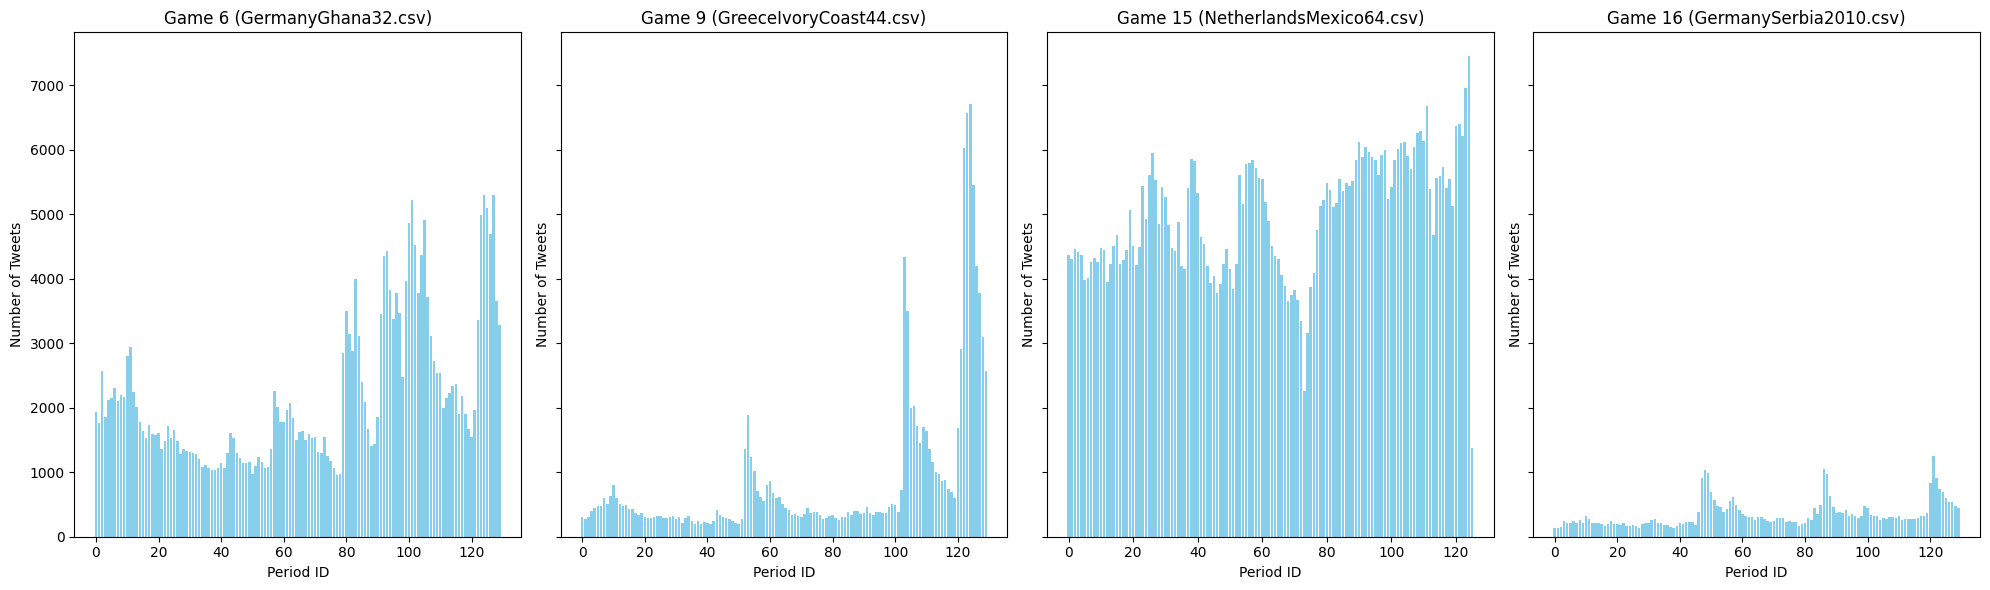

In [38]:
tweet_counts = df_test.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 1, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 6), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename_test.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [39]:
print(f"Total number of periods in the train set: {len(df_test['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_test['PeriodID'].unique())}")

Total number of periods in the train set: 516
Max number of periods in a game in the train set: 130


In [7]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 26.93
  50th percentile length: 26.00
  75th percentile length: 36.00
  90th percentile length: 43.00
  95th percentile length: 46.00
  99th percentile length: 54.00


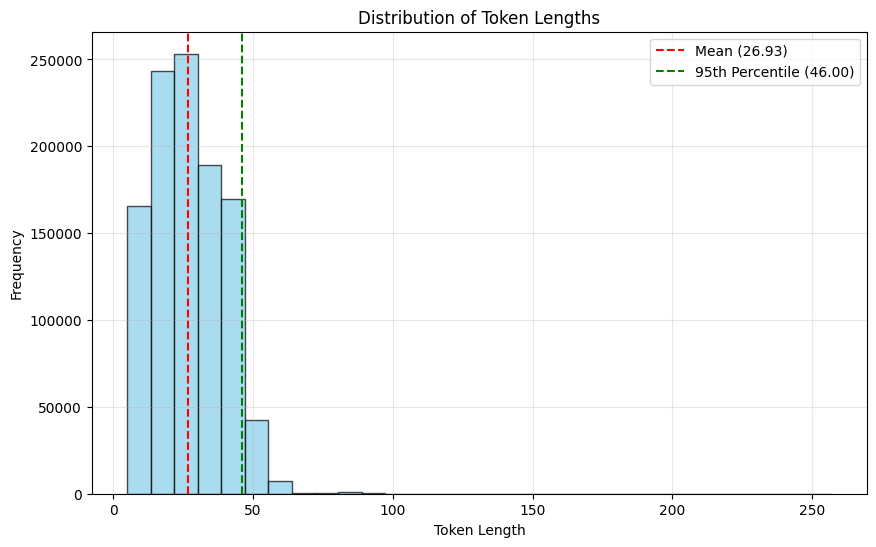

In [8]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [41]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/tokens_bertweet_test.pt")

In [43]:
# input_ids_test, attention_masks_test = torch.load("tokens_bertweet_test.pt")

In [44]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [45]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 33529/33529 [1:03:17<00:00,  8.83it/s]


Done!


In [46]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [48]:
df_test

,ID,MatchID,PeriodID,Timestamp,Tweet,cls
0,6_0,6,0,1403376600000,I Finally get to see Germany play\n#GER 🇩🇪⚽🏆,"[0.077867225, 0.09731847, 0.059819218, -0.1415..."
1,6_0,6,0,1403376600000,RT @Wor1dCup2014: If Any of the Boateng Brothe...,"[-0.063964926, 0.14290993, 0.0746815, -0.16638..."
2,6_0,6,0,1403376600000,Fascinated for this #GERvsGHA match. This will...,"[0.24081214, 0.13553065, 0.030091574, -0.20579..."
3,6_0,6,0,1403376600000,: #GER and #GHA in a few.,"[0.26232398, 0.018381672, -0.0555337, -0.11693..."
4,6_0,6,0,1403376600000,BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...,"[0.10413483, 0.13103765, 0.013799746, 0.014316..."
...,...,...,...,...,...,...
1072923,15_125,15,125,1404064800000,Dutch deserve to be in last 8.Keep their nerve...,"[0.06866108, 0.15437774, 0.2838874, -0.1459453..."
1072924,15_125,15,125,1404064800000,RT @GeniusFootball: RETWEET if you think #MEX ...,"[-0.025768155, 0.14188139, 0.12810758, -0.0807..."
1072925,15_125,15,125,1404064800000,"Hold your head high Mexico, played beautifully...","[-0.021281535, 0.27584612, 0.21054737, -0.0213..."
1072926,15_125,15,125,1404064800000,RT @TheWorIdCup: Mexico fans right now... http...,"[-0.16251707, 0.20360164, 0.09227639, -0.07586..."


In [ ]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels_test.pkl
Saved!


In [51]:
merged_df_test

,ID,aggregated_embedding,MatchID
0,15_0,"[-0.005626861, 0.17002444, 0.1560707, -0.07122...",15
1,15_1,"[-0.012398133, 0.16987626, 0.15416442, -0.0715...",15
2,15_10,"[-0.0063685165, 0.17705764, 0.14571677, -0.061...",15
3,15_100,"[-0.028167112, 0.21267831, 0.11889246, -0.0327...",15
4,15_101,"[-0.021408508, 0.20869574, 0.12005638, -0.0342...",15
...,...,...,...
511,9_95,"[-0.06389925, 0.15774356, 0.10894526, -0.06712...",9
512,9_96,"[-0.06254904, 0.16254315, 0.10645582, -0.07547...",9
513,9_97,"[-0.06544371, 0.15834767, 0.1077392, -0.078381...",9
514,9_98,"[-0.061433755, 0.15302086, 0.0968332, -0.06357...",9


# Data Visualization

Let's visualize our embeddings.

In [72]:
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

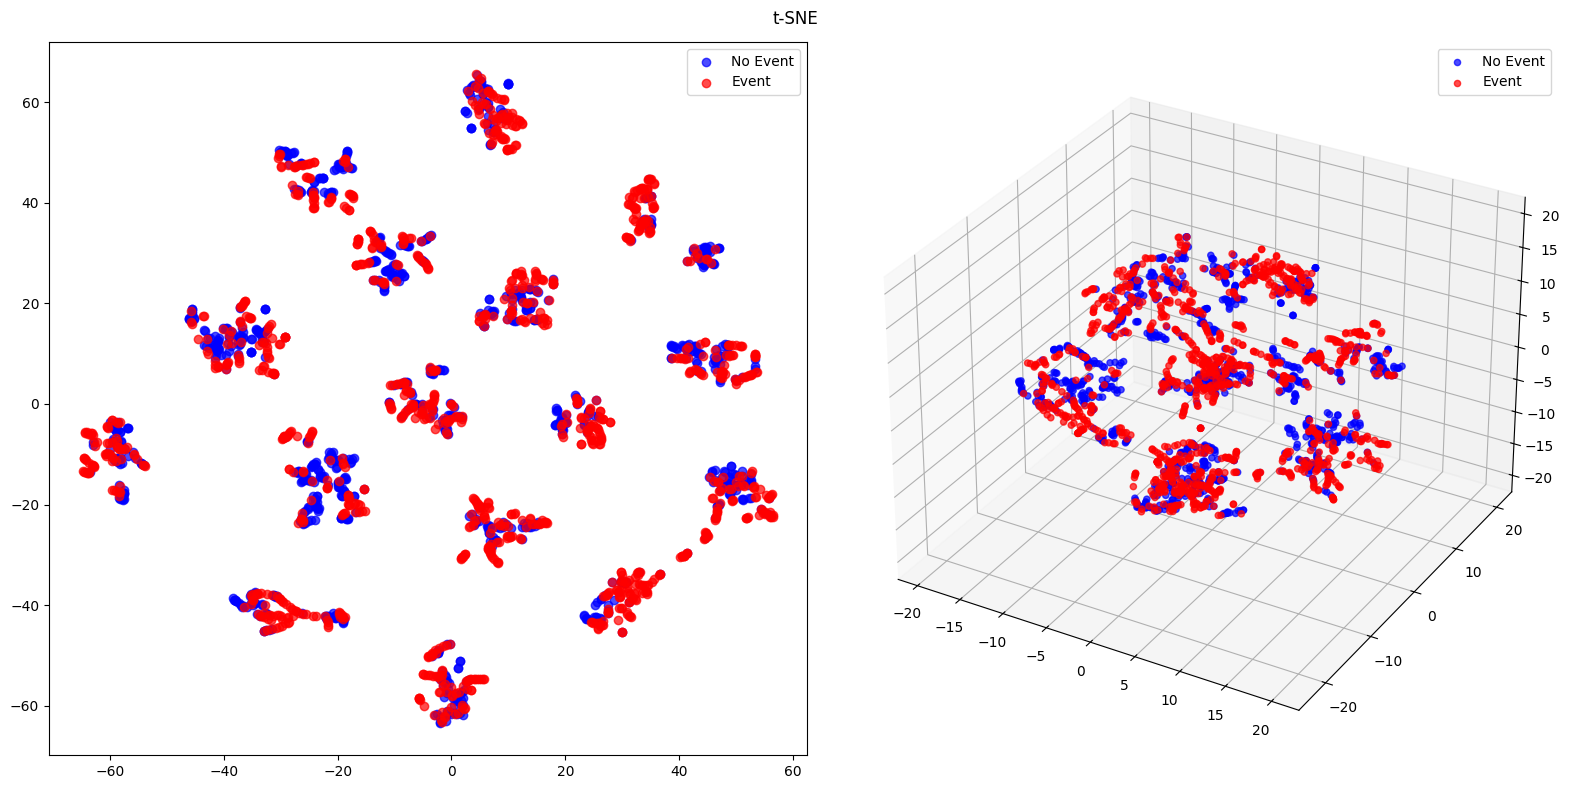

In [73]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


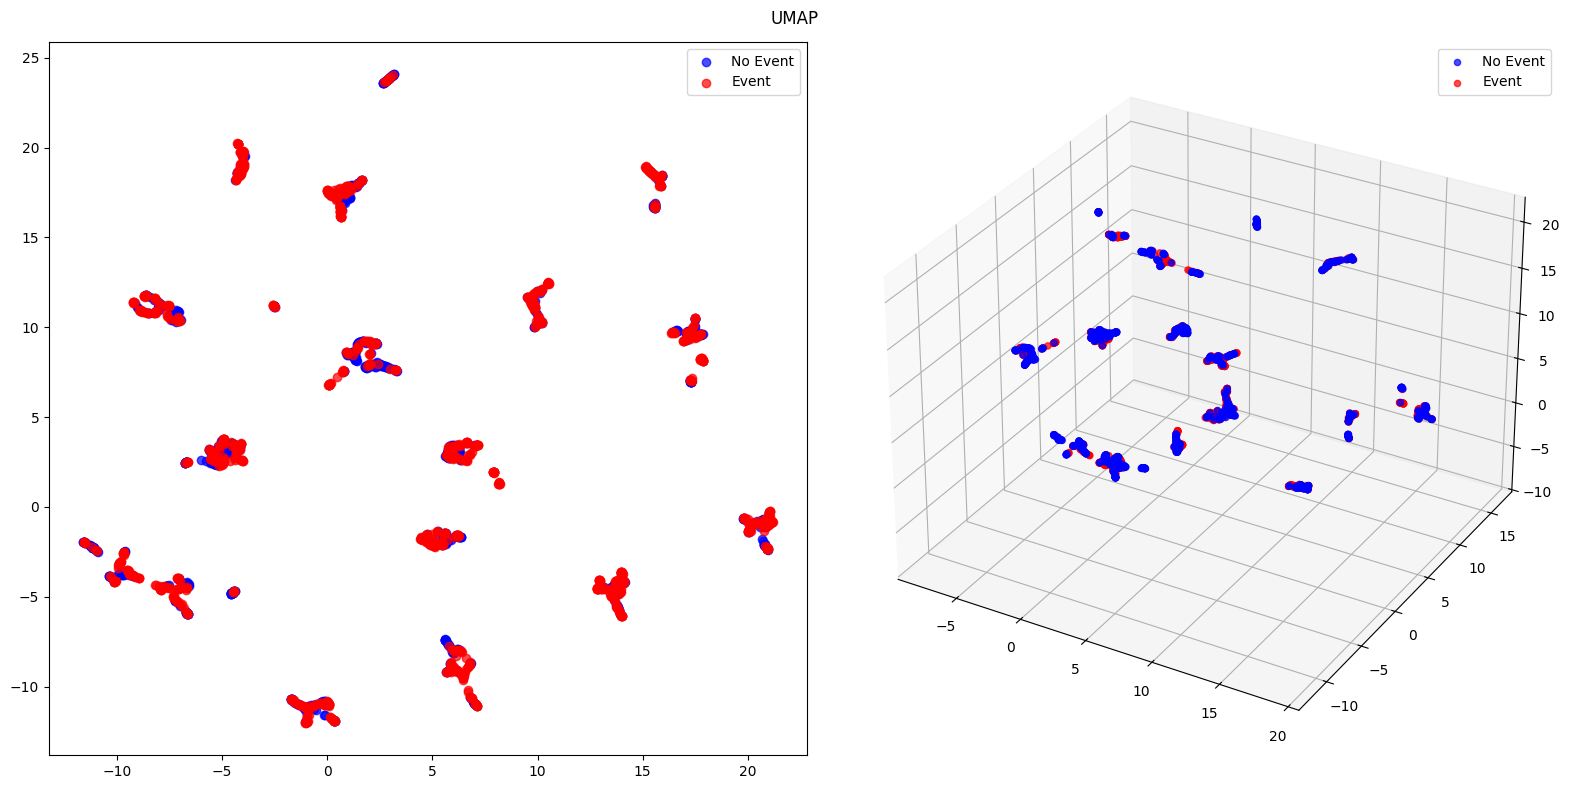

In [76]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Each game is clustered. The 2D and 3D plots are too low-dimensional to efficiently portray the separation between the positive and negative class. This is a suggestion for improving preprocessing to better distinguish the two classes, e.g. remove bad tweets (random, retweets), change embedding, constrative learning, feature engineering, etc.